In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os
workspace_path = '/gdrive/My Drive/Colab Notebooks'
yolov3_path = os.path.join(workspace_path, 'PyTorch-YOLOv3-master')
sample_path = os.path.join(yolov3_path, 'data/samples')

In [ ]:
import sys
sys.path.append(yolov3_path)

In [ ]:
!pip3 install numpy
!pip3 install torch>=1.2
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install tensorboard>=1.15
!pip3 install terminaltables
!pip3 uninstall pillow -y
!pip3 install pillow
!pip3 install tqdm
!pip3 uninstall imgaug -y
!pip3 install imgaug
!pip3 install torchsummary

Uninstalling Pillow-8.2.0:
  Successfully uninstalled Pillow-8.2.0
  Using cached https://files.pythonhosted.org/packages/33/34/542152297dcc6c47a9dcb0685eac6d652d878ed3cea83bf2b23cb988e857/Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
  Using cached https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [ ]:
!wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com"

--2021-04-27 13:37:09--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
ls

'=1.15'  '=1.2'   sample_data/   yolov3.weights


In [ ]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.augmentations import *
from utils.transforms import *

import os
import argparse
import tqdm
import numpy as np

from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

객체 탐지 함수 정의

In [ ]:
def detect_directory(model_path, weights_path, img_path, classes, output_path, 
    batch_size=8, img_size=416, n_cpu=8, conf_thres=0.5, nms_thres=0.5):
    """Detects objects on all images in specified directory and saves output images with drawn detections.

    :param model_path: Path to model definition file (.cfg)
    :type model_path: str
    :param weights_path: Path to weights or checkpoint file (.weights or .pth)
    :type weights_path: str
    :param img_path: Path to directory with images to inference
    :type img_path: str
    :param classes: List of class names
    :type classes: [str]
    :param output_path: Path to output directory
    :type output_path: str
    :param batch_size: Size of each image batch, defaults to 8
    :type batch_size: int, optional
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param n_cpu: Number of cpu threads to use during batch generation, defaults to 8
    :type n_cpu: int, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    """
    dataloader = _create_data_loader(img_path, batch_size, img_size, n_cpu)
    model = load_model(model_path, weights_path)
    img_detections, imgs = detect(
        model,
        dataloader,
        output_path,
        img_size,
        conf_thres,
        nms_thres)
    _draw_and_save_output_images(img_detections, imgs, img_size, output_path)

def detect_image(model, image,
    img_size=416, conf_thres=0.5, nms_thres=0.5):
    """Inferences one image with model.

    :param model: Model for inference
    :type model: models.Darknet
    :param image: Image to inference
    :type image: nd.array
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :return: Detections on image
    :rtype: nd.array
    """
    model.eval()  # Set model to evaluation mode

    # Configure input
    input_img = transforms.Compose([
        DEFAULT_TRANSFORMS, 
        Resize(img_size)])(
            (image, np.zeros((1, 5))))[0].unsqueeze(0)

    if torch.cuda.is_available():
        input_img = input_img.to("cuda")

    # Get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        detections = rescale_boxes(detections[0], img_size, image.shape[:2])
    return to_cpu(detections).numpy()

def detect(model, dataloader, output_path,
    img_size, conf_thres, nms_thres):
    """Inferences images with model.

    :param model: Model for inference
    :type model: models.Darknet
    :param dataloader: Dataloader provides the batches of images to inference
    :type dataloader: DataLoader
    :param output_path: Path to output directory
    :type output_path: str
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :return: List of detections. The coordinates are given for the padded image that is provided by the dataloader. 
        Use `utils.rescale_boxes` to transform them into the desired input image coordinate system before its transformed by the dataloader),
        List of input image paths
    :rtype: [Tensor], [str]
    """
    # Create output directory, if missing
    os.makedirs(output_path, exist_ok=True)

    model.eval()  # Set model to evaluation mode

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    img_detections = []  # Stores detections for each image index
    imgs = []  # Stores image paths

    for (img_paths, input_imgs) in tqdm.tqdm(dataloader, desc="Detecting"):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, conf_thres, nms_thres)

        # Store image and detections
        img_detections.extend(detections)
        imgs.extend(img_paths)
    return img_detections, imgs

결과 출력 함수 정의

In [ ]:
def _draw_and_save_output_images(img_detections, imgs, img_size, output_path):
    """Draws detections in output images and stores them.

    :param img_detections: List of detections
    :type img_detections: [Tensor]
    :param imgs: List of paths to image files
    :type imgs: [str]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    """
    # TODO: Draw class names...
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Iterate through images and save plot of detections
    for (image_path, detections) in tqdm.tqdm(zip(imgs, img_detections), desc="Saving output images"):
        _draw_and_save_output_image(image_path, detections, img_size, colors, output_path)

def _draw_and_save_output_image(image_path, detections, img_size, colors, output_path):
    """Draws detections in output image and stores this.

    :param image_path: Path to input image
    :type image_path: str
    :param detections: List of detections on image
    :type detections: [Tensor]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param colors: List of colors used to draw detections
    :type colors: []
    :param output_path: Path of output directory
    :type output_path: str
    """
    # Create plot
    img = np.array(Image.open(image_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_pred in detections:

        print(f"\t+ Label: {classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")
        
        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(image_path).split(".")[0]
    output_path = os.path.join(output_path, f"{filename}.png")
    plt.show()  # colab 상에서 이미지 출력
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)  # 이미지 파일 출력
    plt.close()

데이터로더

In [ ]:
def _create_data_loader(img_path, batch_size, img_size, n_cpu):
    """Creates a DataLoader for inferencing.

    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ImageFolder(
        img_path,
        transform=transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)]))
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True)
    return dataloader

하이퍼파라미터 설정

In [ ]:
CFG = {
    'model': os.path.join(yolov3_path, "config/yolov3.cfg"),  # YOLOv3 모델 하이퍼파라미터 설정
    'weights': "yolov3.weights",  # pretrained model 가중치 경로
    'images': os.path.join(yolov3_path, "data/samples"),  # 테스트 이미지 경로
    'classes': os.path.join(yolov3_path, "data/coco.names"),  # 테스트 레이블 이름
    'output': workspace_path,  # 테스트 출력 결과 저장 경로
    'batch_size': 1,  # 미니배치 크기
    'img_size': 416,  # 입력 이미지 크기
    'n_cpu': 1,  # 데이터로딩 시 사용할 CPU thread 개수
    'conf_thres': 0.5,  # 객체 탐지 confidence 임계치
    'nms_thres': 0.4  # Non-maximum supression을 위한 IoU 임계치
}
print(CFG)

# Extract class names from file
classes = load_classes(CFG['classes'])  # List of class names

{'model': '/gdrive/My Drive/Colab Notebooks/CVG_과제7/PyTorch-YOLOv3-master/config/yolov3.cfg', 'weights': 'yolov3.weights', 'images': '/gdrive/My Drive/Colab Notebooks/CVG_과제7/PyTorch-YOLOv3-master/data/samples', 'classes': '/gdrive/My Drive/Colab Notebooks/CVG_과제7/PyTorch-YOLOv3-master/data/coco.names', 'output': '/gdrive/My Drive/Colab Notebooks/CVG_과제7', 'batch_size': 1, 'img_size': 416, 'n_cpu': 1, 'conf_thres': 0.5, 'nms_thres': 0.4}


YOLO3 모델 학습에 사용한 데이터셋 레이블 정보

In [ ]:
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


YOLO3 이용한 탐지

Detecting: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
Saving output images: 0it [00:00, ?it/s]

	+ Label: dog | Confidence: 0.9929
	+ Label: bicycle | Confidence: 0.9925
	+ Label: truck | Confidence: 0.9394


<Figure size 432x288 with 0 Axes>

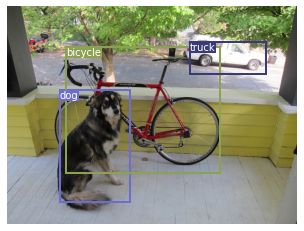

Saving output images: 1it [00:00,  3.77it/s]

	+ Label: bird | Confidence: 0.9970


<Figure size 432x288 with 0 Axes>

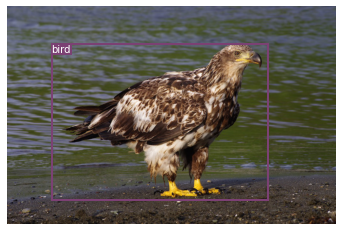

Saving output images: 2it [00:00,  3.87it/s]

	+ Label: person | Confidence: 0.9999
	+ Label: horse | Confidence: 0.9983
	+ Label: dog | Confidence: 0.9939


<Figure size 432x288 with 0 Axes>

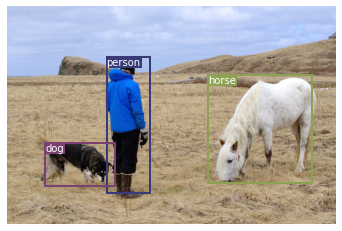

Saving output images: 3it [00:00,  3.98it/s]

	+ Label: giraffe | Confidence: 0.9935
	+ Label: zebra | Confidence: 0.9653


<Figure size 432x288 with 0 Axes>

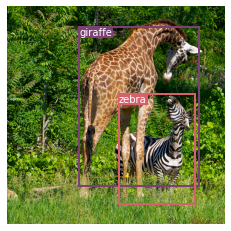

Saving output images: 4it [00:01,  3.85it/s]

	+ Label: horse | Confidence: 0.9847
	+ Label: horse | Confidence: 0.9735
	+ Label: horse | Confidence: 0.9607
	+ Label: horse | Confidence: 0.8771


<Figure size 432x288 with 0 Axes>

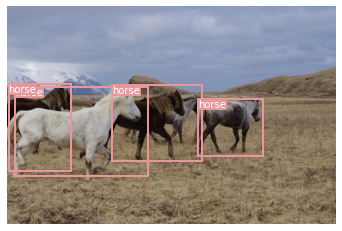

Saving output images: 5it [00:01,  3.92it/s]

	+ Label: person | Confidence: 0.9974
	+ Label: person | Confidence: 0.9792


<Figure size 432x288 with 0 Axes>

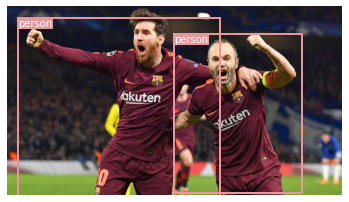

Saving output images: 6it [00:01,  3.71it/s]

	+ Label: person | Confidence: 0.9951
	+ Label: dog | Confidence: 0.9634


<Figure size 432x288 with 0 Axes>

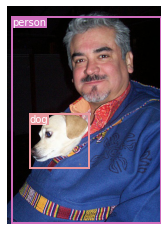

Saving output images: 7it [00:01,  4.11it/s]

	+ Label: chair | Confidence: 0.9868
	+ Label: chair | Confidence: 0.9133
	+ Label: chair | Confidence: 0.7029


<Figure size 432x288 with 0 Axes>

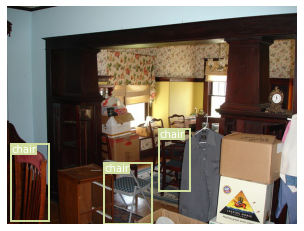

Saving output images: 8it [00:01,  4.32it/s]

	+ Label: car | Confidence: 0.9997
	+ Label: car | Confidence: 0.9926
	+ Label: car | Confidence: 0.9912
	+ Label: car | Confidence: 0.9844
	+ Label: car | Confidence: 0.9757
	+ Label: car | Confidence: 0.9470
	+ Label: traffic light | Confidence: 0.9253
	+ Label: car | Confidence: 0.6944
	+ Label: car | Confidence: 0.6204


<Figure size 432x288 with 0 Axes>

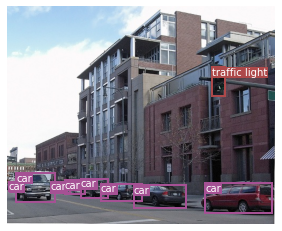

Saving output images: 9it [00:02,  4.03it/s]


In [ ]:
detect_directory(
    CFG['model'],
    CFG['weights'],
    CFG['images'],
    classes,
    CFG['output'],
    batch_size=CFG['batch_size'],
    img_size=CFG['img_size'],
    n_cpu=CFG['n_cpu'],
    conf_thres=CFG['conf_thres'],
    nms_thres=CFG['nms_thres'])